In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
import sys
import os

sys.path.append(r'C:\Program Files\QGIS 3.22.3\apps\qgis\python') #this is important for loading qgis library
sys.path.append(r'C:\Program Files\QGIS 3.22.3\apps\qgis\python\plugins') #this is important for loading processing library

In [6]:
import qgis
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from PyQt5.QtCore import *
from qgis.analysis import QgsNativeAlgorithms

In [7]:
%matplotlib inline

import geopandas as gpd
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from pulp import *

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_10 = str(pd.__version__) >= LooseVersion("1.0.0")
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_11 = str(pd.__version__) >= LooseVersion("1.1.0")
C:\Users\user\AppData\Ro

# Day 2 - Part II Create QGIS Geoprocessing tools <img src="./Resources/sla.png" width="100" align ="right"/>

## PyQt5 Thread (optional)

In an event-driven application like QGIS, clicking on a button creates an event. The application handles the event to produce the output. However, any time the PyQt application spends time doing something in the code, window communication and GUI interaction are frozen.

The solution is simple: to use mutli-thread. A *thread* is a small set of instructions designed to be scheduled and executed by the CPU independently of the parent process. PyQt provides an straightforward interface to do exactly that.


This is built around two classes: *QRunnable* and *QThreadPool*. The former is the container for the work you want to perform, while the latter is the method by which you pass that work to alternate threads.

In [4]:
import time

from PyQt5.QtCore import (QCoreApplication, QObject, QRunnable, QThread,
                          QThreadPool, pyqtSignal)

# Subclassing QThread
# http://qt-project.org/doc/latest/qthread.html
class AThread(QThread):

    def run(self):
        count = 0
        while count < 5:
            time.sleep(1)
            print("A Increasing")
            count += 1

# Subclassing QObject and using moveToThread
# http://blog.qt.digia.com/blog/2007/07/05/qthreads-no-longer-abstract
class SomeObject(QObject):

    finished = pyqtSignal()

    def long_running(self):
        count = 0
        while count < 5:
            time.sleep(1)
            print("B Increasing")
            count += 1
        self.finished.emit()

# Using a QRunnable
# http://qt-project.org/doc/latest/qthreadpool.html
# Note that a QRunnable isn't a subclass of QObject and therefore does
# not provide signals and slots.
class Runnable(QRunnable):

    def run(self):
        count = 0
        app = QCoreApplication.instance()
        while count < 5:
            print("C Increasing")
            time.sleep(1)
            count += 1
        app.quit()

def using_q_thread():
    app = QCoreApplication([])
    thread = AThread()
    thread.finished.connect(app.exit)
    thread.start()
    sys.exit(app.exec_())

def using_move_to_thread():
    app = QCoreApplication([])
    objThread = QThread()
    obj = SomeObject()
    obj.moveToThread(objThread)
    obj.finished.connect(objThread.quit)
    objThread.started.connect(obj.long_running)
    objThread.finished.connect(app.exit)
    objThread.start()
    sys.exit(app.exec_())

def using_q_runnable():
    app = QCoreApplication([])
    runnable = Runnable()
    QThreadPool.globalInstance().start(runnable)
    sys.exit(app.exec_())

In [5]:
using_q_thread()
# using_move_to_thread()
# using_q_runnable()

SystemExit: 0

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


A Increasing
A Increasing
A Increasing
A Increasing
A Increasing


## PyQGIS Thread

QGIS use threads to maintain a responsive user interface when it is working on heavy tasks.

A *QgsTask* is a container for the code to be performed in the background, and the task manager *QgsTaskManager* is used to control the running of the tasks. These classes simplify background processing in QGIS by providing mechanisms for signaling, progress reporting and access to the status for background processes. 

> Any background task (regardless of how it is created) must NEVER use any QObject that lives on the main thread, such as accessing QgsVectorLayer, QgsProject or perform any GUI based operations like creating new widgets or interacting with existing widgets. Qt widgets must only be accessed or modified from the main thread. Data that is used in a task must be copied before the task is started. Attempting to use them from background threads will result in crashes.

```python
from time import sleep
def heavy_fun(task):
    QgsMessageLog.logMessage("sleep 10 seconds", 'MyHeavyFunction', Qgis.Info)
    sleep(10)
    
def finished(exception, value=None):
    QgsMessageLog.logMessage("finished", 'MyHeavyFunction', Qgis.Info)
    
# Create a few tasks
task1 = QgsTask.fromFunction('heavy function example', heavy_fun, on_finished=finished)

QgsApplication.taskManager().addTask(task1)
```

QgsMessageLog is for messages to communicate issues to the user. The output of the QgsMessageLog is shown in the Log Messages Panel.

The python built in logging module is for debugging on the level of the QGIS Python API (PyQGIS). It is recommended for Python script developers that need to debug their python code, e.g. feature ids or geometries

QgsLogger is for messages for QGIS internal debugging / developers (i.e. you suspect something is triggered by some broken code). Messages are only visible with developer versions of QGIS.

> Use of the Python print statement is unsafe to do in any code which may be multithreaded and extremely slows down the algorithm. This includes expression functions, renderers, symbol layers and Processing algorithms (amongst others). In these cases you should always use the python logging module or thread safe classes (QgsLogger or QgsMessageLog) instead.

## Creating processing scripts

Let’s create a processing script in the processing toolbox and have a look at the following code. 

This script defines a Processing algorithm that performs a buffer operation with a user defined buffer distance on a vector layer that is specified by the user, after first smoothing the layer.

```python
from qgis.core import (QgsProcessingAlgorithm,
       QgsProcessingParameterNumber,
       QgsProcessingParameterFeatureSource,
       QgsProcessingParameterFeatureSink)

from qgis import processing

class algTest(QgsProcessingAlgorithm):
    INPUT_BUFFERDIST = 'BUFFERDIST'
    OUTPUT_BUFFER = 'OUTPUT_BUFFER'
    INPUT_VECTOR = 'INPUT_VECTOR'

    def __init__(self):
        super().__init__()

    def name(self):
        return "algTest"

    def displayName(self):
        return "algTest script"

    def createInstance(self):
        return type(self)()

    def initAlgorithm(self, config=None):
        self.addParameter(QgsProcessingParameterFeatureSource(
            self.INPUT_VECTOR, "Input vector"))
        self.addParameter(QgsProcessingParameterNumber(
            self.INPUT_BUFFERDIST, "Buffer distance",
            QgsProcessingParameterNumber.Double,
            50.0))
        self.addParameter(QgsProcessingParameterFeatureSink(
            self.OUTPUT_BUFFER, "Output buffer"))

    def processAlgorithm(self, parameters, context, feedback):
        #DO SOMETHING
        algresult = processing.run("native:smoothgeometry",
            {'INPUT': parameters[self.INPUT_VECTOR],
             'ITERATIONS':2,
             'OFFSET':0.25,
             'MAX_ANGLE':180,
             'OUTPUT': 'memory:'},
            context=context, feedback=feedback, is_child_algorithm=True) ### note: is_child_algorithm true 
        smoothed = algresult['OUTPUT']
        algresult = processing.run('native:buffer',
            {'INPUT': smoothed,
            'DISTANCE': parameters[self.INPUT_BUFFERDIST],
            'SEGMENTS': 5,
            'END_CAP_STYLE': 0,
            'JOIN_STYLE': 0,
            'MITER_LIMIT': 10,
            'DISSOLVE': True,
            'OUTPUT': parameters[self.OUTPUT_BUFFER]},
            context=context, feedback=feedback, is_child_algorithm=True) ### note: is_child_algorithm true 
        buffered = algresult['OUTPUT']
        return {self.OUTPUT_BUFFER: buffered}
```

After doing the necessary imports, the following QgsProcessingAlgorithm functions are specified:

* `name()`: The id of the algorithm (lowercase).
* `displayName()`: A human readable name for the algorithm.
* `createInstance()`: Create a new instance of the algorithm class.
* `initAlgorithm()`: Configure the parameterDefinitions and outputDefinitions.

Here we describe the parameters and output of the algorithm. In this case, a feature source for the input, a feature sink for the result and a number for the buffer distance.

* `processAlgorithm()`: Do the work.

Here we first run the smoothgeometry algorithm to smooth the geometry, and then we run the buffer algorithm on the smoothed output. To be able to run algorithms from within another algorithm we have to set the `is_child_algorithm` argument to True. You can see how input and output parameters are used as parameters to the smoothgeometry and buffer algorithms.

The first parameter to the constructors is the name of the parameter, and the second is the description of the parameter (for the user interface). The rest of the constructor parameters are parameter type specific.

### Parameter Types 

There are a number of different parameter types available for input and output. Below is an alphabetically sorted list:

* QgsProcessingParameterAggregate
* QgsProcessingParameterAuthConfig
* QgsProcessingParameterBand
* QgsProcessingParameterBoolean
* QgsProcessingParameterColor
* QgsProcessingParameterCoordinateOperation
* QgsProcessingParameterCrs
* QgsProcessingParameterDatabaseSchema
* QgsProcessingParameterDatabaseTable
* QgsProcessingParameterDateTime
* QgsProcessingParameterDistance
* QgsProcessingParameterEnum
* QgsProcessingParameterExpression
* QgsProcessingParameterExtent
* QgsProcessingParameterFeatureSink
* QgsProcessingParameterFeatureSource
* QgsProcessingParameterField
* QgsProcessingParameterFieldMapping
* QgsProcessingParameterFile
* QgsProcessingParameterFileDestination
* QgsProcessingParameterFolderDestination
* QgsProcessingParameterLayout
* QgsProcessingParameterLayoutItem
* QgsProcessingParameterMapLayer
* QgsProcessingParameterMapTheme
* QgsProcessingParameterMatrix
* QgsProcessingParameterMeshLayer
* QgsProcessingParameterMultipleLayers
* QgsProcessingParameterNumber
* QgsProcessingParameterPoint
* QgsProcessingParameterProviderConnection
* QgsProcessingParameterRange
* QgsProcessingParameterRasterDestination
* QgsProcessingParameterRasterLayer
* QgsProcessingParameterScale
* QgsProcessingParameterString
* QgsProcessingParameterVectorDestination
* QgsProcessingParameterVectorLayer
* QgsProcessingParameterVectorTileWriterLayers

See [here](https://docs.qgis.org/testing/en/docs/user_manual/processing/scripts.html#input-and-output-types-for-processing-algorithms) for more details.

The input can be turned into QGIS classes using the `parameterAs` functions of QgsProcessingAlgorithm. For instance to get the number provided for the buffer distance as a double:

```python
self.parameterAsDouble(parameters, self.INPUT_BUFFERDIST, context))
```

The `processAlgorithm` function should return a dictionary containing values for every output defined by the algorithm. This allows access to these outputs from other algorithms, including other algorithms contained within the same model.

### Communicating with the user

If the algorithm takes a long time to process, we need to inform the user about the progress. The feedback object passed to processAlgorithm() should be used for user feedback / interaction. 

The progress text and progressbar can be updated using two methods: `setProgressText(text)` and `setProgress(percent)`. The `setProgress()` function can be used to updated the progress bar (0 to 100). This is very useful if your algorithm takes a long time to complete.

We can provide more information by using `pushCommandInfo(text)`, `pushDebugInfo(text)`, `pushInfo(text)` and `reportError(text)`.

If your script has a problem, the correct way of handling it is to raise a QgsProcessingException. You can pass a message as an argument to the constructor of the exception. Processing will take care of handling it and communicating with the user, depending on where the algorithm is being executed from (toolbox, modeler, Python console, …)

The feedback object provides an `isCanceled()` method that should be monitored to enable cancelation of the algorithm by the user. 

> Algorithms should avoid using other forms of providing feedback to users, such as print statements or logging to QgsMessageLog, and should always use the feedback object instead. This allows verbose logging for the algorithm, and is also thread-safe (which is important, given that algorithms are typically run in a background thread).

## Travelling Salesman Problem (TSP) 

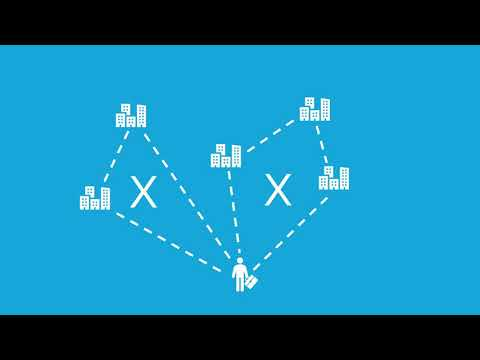

In [1]:
from IPython.display import Audio,Image, YouTubeVideo
id='1pmBjIZ20pE'
YouTubeVideo(id=id,width=600,height=300, start=0)

The Travelling Salesman Problem (TSP) tries to find, given the weight (distance) between all points where a salesman has to visit, the route so that:

* The total distance (cost) which the salesman travels is minimized.
* The salesman returns to the starting point.
* Note that for a complete graph, the salesman visits each point once.

The function travelling_salesman_problem allows for incomplete graphs by finding all-pairs shortest paths, effectively converting the problem to a complete graph problem. It calls one of the approximate methods on that problem and then converts the result back to the original graph using the previously found shortest paths.

TSP is an NP-hard problem in combinatorial optimization, important in operations research and theoretical computer science. A problem is NP-hard if an algorithm for solving it can be translated into one for solving any NP-problem (nondeterministic polynomial time) problem.

Implementation of approximate algorithms for solving and approximating the TSP problem.

Categories of algorithms which are implemented:
* Greedy
* Simulated Annealing (SA)
* Threshold Accepting (TA)
* Christofides (provides a 3/2-approximation of TSP)
* Asadpour Asymmetric Traveling Salesman Algorithm

This implementation of a `greedy` algorithm is based on the following:

* The algorithm adds a node to the solution at every iteration.
* The algorithm selects a node not already in the cycle whose connection to the previous node adds the least cost to the cycle.

A `greedy` algorithm does not always give the best solution. However, it can construct a first feasible solution which can be passed as a parameter to an iterative improvement algorithm such as `Simulated Annealing`, or `Threshold Accepting`.

'Christofides' algorithm computes a 3/2-approximation of the traveling salesman problem in a complete undirected graph. see [here](https://en.wikipedia.org/wiki/Christofides_algorithm).

`Simulated Annealing` is a metaheuristic local search algorithm. This function uses simulated annealing to approximate the minimal cost cycle through the nodes. The main characteristic of this algorithm is that it accepts even solutions which lead to the increase of the cost in order to escape from low quality local optimal solutions.

Starting from a suboptimal solution, `simulated annealing` perturbs that solution, occasionally accepting changes that make the solution worse to escape from a locally optimal solution. **The chance of accepting such changes decreases over the iterations to encourage an optimal result**. In summary, the function returns a cycle starting at source for which the total cost is minimized. It also returns the cost.

This algorithm needs an initial solution. If not provided, it is constructed by a simple greedy algorithm. At every iteration, the algorithm selects thoughtfully a neighbor solution. Consider $c(x)$ cost of current solution and $c(x')$ cost of a neighbor solution. If $c(x') - c(x) <=0 $ then the neighbor solution becomes the current solution for the next iteration. Otherwise, the algorithm accepts the neighbor solution with probability $p = exp(-[c(x')-c(x)]/temp)$. Otherwise the current solution is retained.

*temp* is a parameter of the algorithm and represents temperature.

`Threshold Accepting` is a metaheuristic local search algorithm. The main characteristic of this algorithm is that it accepts even solutions which lead to the increase of the cost in order to escape from low quality local optimal solutions.

This algorithm needs an initial solution. This solution can be constructed by a simple greedy algorithm. At every iteration, it selects thoughtfully a neighbor solution. Consider $c(x)$ cost of current solution and $c(x')$ cost of neighbor solution. If $c(x') - c(x) <=threshold $ then the neighbor solution becomes the current solution for the next iteration, where the threshold is named threshold.

In comparison to the Simulated Annealing algorithm, the Threshold Accepting algorithm does not accept very low quality solutions (due to the presence of the threshold value). In the case of Simulated Annealing, even a very low quality solution can be accepted with probability.

The `asadpour` approximate solution is one of the best known approximations for the asymmetric traveling salesman problem developed by Asadpour et al. The algorithm first solves the Held-Karp relaxation to find a lower bound for the weight of the cycle. Next, it constructs an exponential distribution of undirected spanning trees where the probability of an edge being in the tree corresponds to the weight of that edge using a maximum entropy rounding scheme. Next we sample that distribution  times and save the minimum sampled tree once the direction of the arcs is added back to the edges. Finally, we augment then short circuit that graph to find the approximate tour for the salesman.

This `traveling_salesman_problem` proceeds in two steps. First, it creates a complete graph using the all-pairs shortest_paths between nodes in nodes. Edge weights in the new graph are the lengths of the paths between each pair of nodes in the original graph. Second, an algorithm (default: `christofides` for undirected and `asadpour_atsp` for directed) is used to approximate the minimal `Hamiltonian cycle` on this new graph. `Hamiltonian cycle` is a path in an undirected or directed graph that visits each vertex exactly once.